In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy import stats
import numpy as np
import seaborn as sns 
from scipy.stats import ttest_ind, pearsonr, spearmanr, mannwhitneyu
import statsmodels.stats.proportion as proportion

In [2]:
!pip install termcolor
from termcolor import colored

In [3]:
pip install xlsxwriter

Note: you may need to restart the kernel to use updated packages.


In [4]:
df_data = pd.read_excel('Новый диплом датасет.xlsx', sheet_name='Данные')
df_clients = pd.read_excel('Новый диплом датасет.xlsx', sheet_name = 'Clients')
df_region = pd.read_excel('Новый диплом датасет.xlsx', sheet_name = 'Region_dict')

df_data = df_data[~((df_data['id_client'].isnull()) | (df_data['amt_payment'].isnull()) | (df_data['dtime_pay'].isnull()))]

In [5]:
merged_df = df_data.merge(df_clients, on = 'id_client', how = 'outer')
merged_df = merged_df.merge(df_region, on = 'id_trading_point')

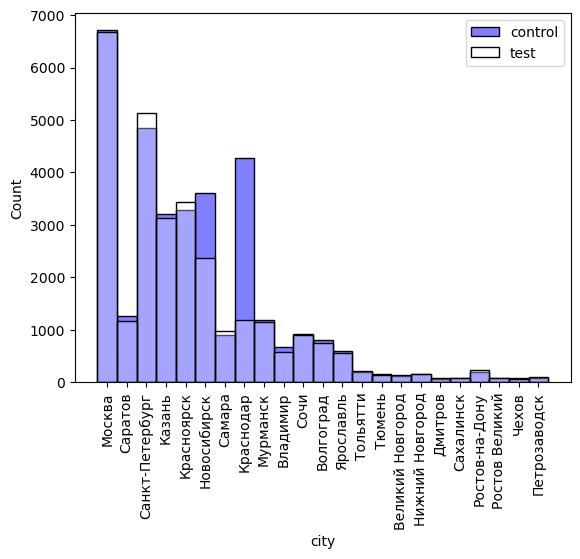

In [6]:

sns.histplot(merged_df[merged_df['nflag_test'] == 0]['city'], color='blue', alpha=0.5, label='control')
sns.histplot(merged_df[merged_df['nflag_test'] == 1]['city'], color='white', alpha=0.3, label='test')

plt.xticks(rotation=90)
plt.legend()
plt.show()

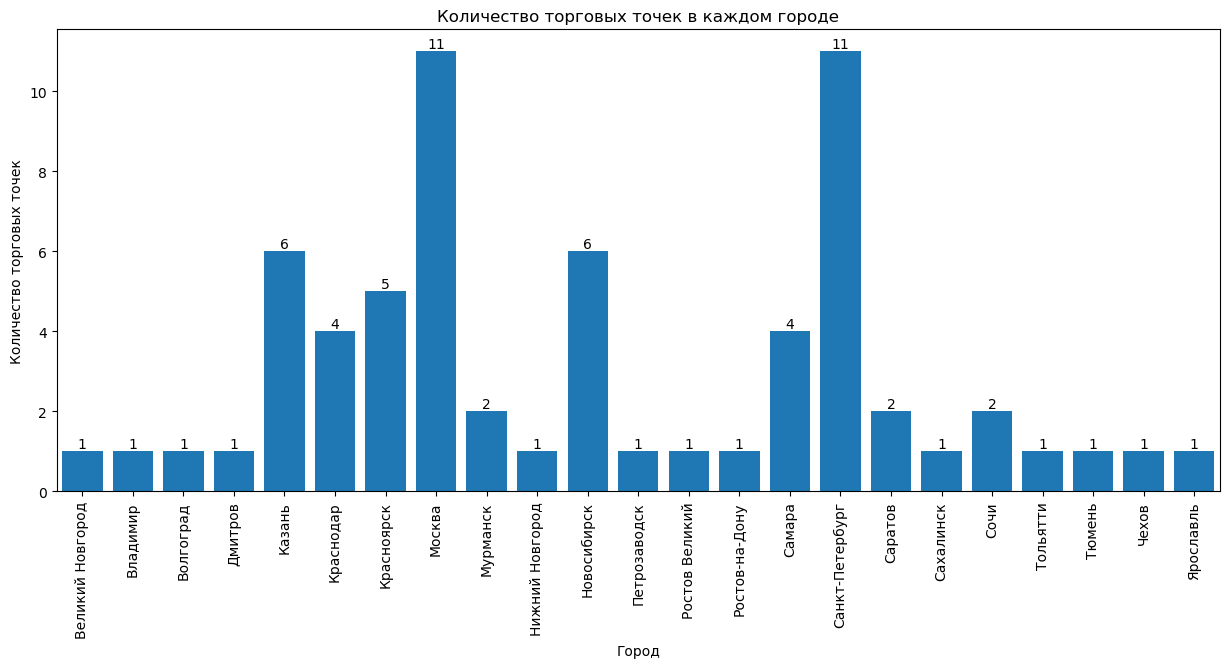

In [7]:
points_cnt = merged_df.groupby('city')['id_trading_point'].nunique()

plt.figure(figsize=(15, 6))
points_cnt.plot(kind='bar', color='orange')
plt.xlabel('Город',)
plt.ylabel('Количество торговых точек')
plt.title('Количество торговых точек в каждом городе')

cities = points_cnt.index
x = range(len(cities))
plt.bar(x, points_cnt, tick_label=cities, align='center')

for i, count in enumerate(points_cnt):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.xticks(rotation=90)  
plt.show()

In [8]:
payment_aggregation = df_data.groupby('id_client')['amt_payment'].sum().reset_index()

In [9]:
merged_df['amt_payment'].fillna(0, inplace=True)
df_cl = merged_df.groupby(['id_client','id_trading_point','city']).agg({'id_order':'count', 'amt_payment':'sum'}).reset_index()
df_fin = df_cl.merge(df_clients[['id_client','dtime_ad','nflag_test']], on = 'id_client')

In [10]:
df_fin['payment_flag'] = np.where(df_fin['amt_payment'] > 0, 1, 0)

In [11]:
empty_trading_points = []

for i in df_fin['id_trading_point'].unique():
    
    df_loc = df_fin[df_fin['id_trading_point']==i]
    sum_a = df_fin[(df_fin['id_trading_point']==i) & (df_fin['nflag_test']==0)].sum()['amt_payment'].sum()
    sum_b = df_fin[(df_fin['id_trading_point']==i) & (df_fin['nflag_test']==1)].sum()['amt_payment'].sum()
    if (sum_a == 0) | (sum_b == 0):
        empty_trading_points.append(i)
        
print(empty_trading_points)


C:\Users\kirdy\AppData\Local\Temp\ipykernel_12456\3247702243.py:6: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  sum_a = df_fin[(df_fin['id_trading_point']==i) & (df_fin['nflag_test']==0)].sum()['amt_payment'].sum()
C:\Users\kirdy\AppData\Local\Temp\ipykernel_12456\3247702243.py:7: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  sum_b = df_fin[(df_fin['id_trading_point']==i) & (df_fin['nflag_test']==1)].sum()['amt_payment'].sum()
C:\Users\kirdy\AppData\Local\Temp\ipykernel_12456\3247702243.py:6: FutureWarning: The default value of num

[26, 739, 866, 46, 1099, 1015, 603, 810, 800, 228, 4, 1, 7]


C:\Users\kirdy\AppData\Local\Temp\ipykernel_12456\3247702243.py:6: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  sum_a = df_fin[(df_fin['id_trading_point']==i) & (df_fin['nflag_test']==0)].sum()['amt_payment'].sum()
C:\Users\kirdy\AppData\Local\Temp\ipykernel_12456\3247702243.py:7: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  sum_b = df_fin[(df_fin['id_trading_point']==i) & (df_fin['nflag_test']==1)].sum()['amt_payment'].sum()
C:\Users\kirdy\AppData\Local\Temp\ipykernel_12456\3247702243.py:6: FutureWarning: The default value of num

In [12]:
empty_control_or_test_points = []

for i in df_fin['id_trading_point'].unique():
    
    c_a = df_fin[(df_fin['id_trading_point']==i) & (df_fin['nflag_test']==0)].count()['id_client']
    c_b = df_fin[(df_fin['id_trading_point']==i) & (df_fin['nflag_test']==1)].count()['id_client']
    if (c_a == 0) | (c_b == 0):
        empty_control_or_test_points.append(i)
        
print(empty_control_or_test_points)

[739, 866, 1099, 1015, 603, 810, 800, 228]


In [13]:
df_merged_point_city = df_fin[~df_fin['id_trading_point'].isin(empty_control_or_test_points + empty_trading_points)]

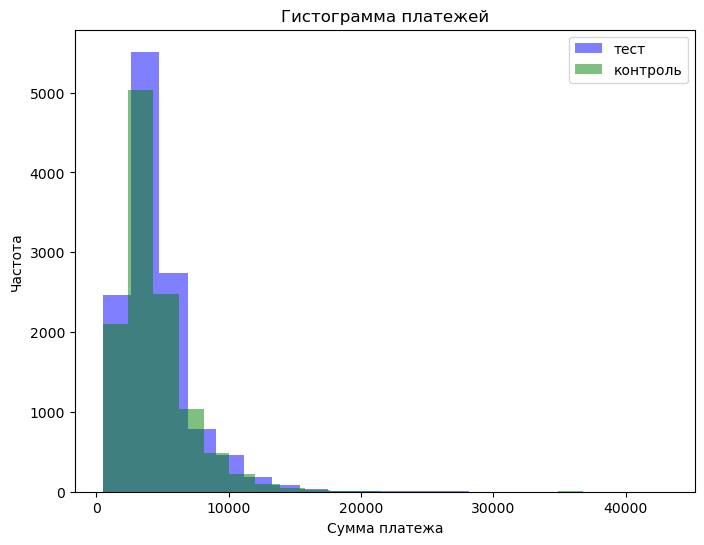

In [16]:
plt.figure(figsize=(8,6))
plt.xlabel('Сумма платежа')
plt.ylabel('Частота')
plt.title('Гистограмма платежей')

test = df_merged_point_city[(df_merged_point_city['nflag_test'] == 1) & (df_merged_point_city['amt_payment'] > 0)]['amt_payment']
control = df_merged_point_city[(df_merged_point_city['nflag_test'] == 0) & (df_merged_point_city['amt_payment'] > 0)]['amt_payment']

plt.hist(test, bins=20, alpha=0.5, color='blue', label='тест')
plt.hist(control, bins=20, alpha=0.5, color='green', label='контроль')

plt.legend(loc='upper right')
plt.show()

In [17]:
def test_calc(r1, r2, alpha = 0.05):
    
    s,p = ttest_ind(r1,r2)
    
    if p < alpha:
        print('Гипотеза H0 не подтверждается: средние не равны')
    else:
        print('Гипотеза H0 подтверждается: средние равны')
    
    print('Среднее значение 1 ряда', r1.mean())
    print('Среднее значение 2 ряда', r2.mean())
    print('Разница средних = ', r1.mean()-r2.mean())
    print('P_value =',p)
    return s, p

In [18]:
def test_calc_conv(r1, r2, alpha = 0.05):
    
    s,p = ttest_ind(r1,r2)
    
    if p < alpha:
         print('Существует статистически значимая разница между конверсиями (p-value < {:.2f})'.format(alpha))
    else:
        print('Нет статистически значимой разницы между конверсиями (p-value >= {:.2f})'.format(alpha))
            
    print('Среднее значение 1 ряда', r1.mean())
    print('Среднее значение 2 ряда', r2.mean())
    print('Разница средних = ', r1.mean()-r2.mean())
    print('P_value =',p)
    return s, p

In [19]:
def mann_whitney_func(r1, r2, alpha=0.05):
    
    s, p = mannwhitneyu(r1, r2)
    
    if p < alpha:
        print('Распределения не равны')
    else:
        print('Распределения равны')
    
    print('P_value =',p)
    return s, p

In [20]:
test_calc(control, test)

Гипотеза H0 не подтверждается: средние не равны
Среднее значение 1 ряда 4379.020091798736
Среднее значение 2 ряда 4513.450752338349
Разница средних =  -134.4306605396132
P_value = 0.00012983442156519871


(-3.8274003597445527, 0.00012983442156519871)

In [24]:
test_group = df_merged_point_city[df_merged_point_city['nflag_test'] == 1]
control_group = df_merged_point_city[df_merged_point_city['nflag_test'] == 0]

test_group_paid = test_group[test_group['payment_flag'] == 1]
control_group_paid = control_group[control_group['payment_flag'] == 1]


test_conversion = test_group_paid.agg({'id_client': 'count'})
total_test = test_group.agg({'id_client': 'count'})
test_conversion['conv'] = round(test_conversion['id_client'] / total_test['id_client'] * 100, 2)
print(test_conversion[1])

control_conversion = control_group_paid.agg({'id_client': 'count'})
total_control = control_group.agg({'id_client': 'count'})
control_conversion['conv'] = round(control_conversion['id_client'] / total_control['id_client'] * 100, 2)
print(control_conversion[1])

54.14
49.92


In [22]:
test_calc_conv(control_conversion,test_conversion)

Нет статистически значимой разницы между конверсиями (p-value >= 0.05)
Среднее значение 1 ряда 5798.46
Среднее значение 2 ряда 6174.57
Разница средних =  -376.1099999999997
P_value = 0.9683429064339191


(-0.0447923414983418, 0.9683429064339191)

In [23]:
print(colored('ВЫВОД: Статистически значимой разницы в конверсии не обнаружено, так как p-value выше выбранного порога ошибки первого рода', 'black', attrs=['bold']))

ВЫВОД: Статистически значимой разницы в конверсии не обнаружено, так как p-value выше выбранного порога ошибки первого рода


In [23]:
mann_whitney_func(control, test)

Распределения не равны
P_value = 2.387310953894081e-23


(249351971.5, 2.387310953894081e-23)

In [24]:
print(colored('ВЫВОД: Таким образом,  существует статистически значимое различие между рассматриваемыми распределениями выборок r1 и r2, так как  значение (p_value) получилось очень маленьким, что значительно меньше уровня значимости alpha (0.05). Следовательно нулевая гипотеза отвергается, согласно которой распределения r1 и r2 равны.', 'black', attrs=['bold']))

ВЫВОД: Таким образом,  существует статистически значимое различие между рассматриваемыми распределениями выборок r1 и r2, так как  значение (p_value) получилось очень маленьким, что значительно меньше уровня значимости alpha (0.05). Следовательно нулевая гипотеза отвергается, согласно которой распределения r1 и r2 равны.


In [25]:
msk = df_merged_point_city[df_merged_point_city['city']=='Москва']

In [26]:
test_msk = msk[msk['nflag_test'] == 1]['amt_payment']
control_msk = msk[msk['nflag_test'] == 0]['amt_payment']

In [27]:
test_calc(control_msk, test_msk,alpha = 0.05)

Гипотеза H0 не подтверждается: средние не равны
Среднее значение 1 ряда 1986.18059125964
Среднее значение 2 ряда 2367.9590805347243
Разница средних =  -381.7784892750842
P_value = 1.757549439555765e-14


(-7.676511027843395, 1.757549439555765e-14)

In [28]:
test_gr_msk = msk[msk['nflag_test'] == 1]
control_gr_msk = msk[msk['nflag_test'] == 0]

test_gr_paid_msk = test_gr_msk[test_gr_msk['payment_flag'] == 1]
control_gr_paid_msk = control_gr_msk[control_gr_msk['payment_flag'] == 1]


test_conversion_msk = test_gr_paid_msk.agg({'id_client': 'count'})
total_test_msk = test_msk.agg({'id_client': 'count'})
test_conversion_msk['conv'] = round(test_conversion_msk['id_client'] / total_test_msk['id_client'] * 100, 2)
print(test_conversion_msk)

control_conversion_msk = control_gr_paid_msk.agg({'id_client': 'count'})
total_control_msk = control_msk.agg({'id_client': 'count'})
control_conversion_msk['conv'] = round(control_conversion_msk['id_client'] / total_control_msk['id_client'] * 100, 2)
print(control_conversion_msk)

id_client    3334.00
conv           54.35
dtype: float64
id_client    3037.00
conv           48.79
dtype: float64


In [30]:
test_calc_conv(control_conversion_msk, test_conversion_msk,alpha = 0.05)

Нет статистически значимой разницы между конверсиями (p-value >= 0.05)
Среднее значение 1 ряда 1542.895
Среднее значение 2 ряда 1694.175
Разница средних =  -151.27999999999997
P_value = 0.9518363994925305


(-0.06819275744808795, 0.9518363994925305)

In [253]:
print(colored('ВЫВОД: Нет статистически значимой разницы между конверсиями, в городе Москва, так как значение p-value больше 0.05', 'black', attrs=['bold']))

ВЫВОД: Нет статистически значимой разницы между конверсиями, в городе Москва, так как значение p-value больше 0.05


In [254]:
mann_whitney_func(control_msk, test_msk)

Распределения не равны
P_value = 7.010591402203484e-16


(17582441.5, 7.010591402203484e-16)

In [255]:
print(colored('ВЫВОД: распределения двух выборок (для контрольной и тестовой группы в городе Москва) не равны, так как уровень значимости (p-value) очень низкий и меньше заданного порога (alpha = 0.05), что указывает на статистически значимую разницу между выборками.', 'black', attrs=['bold']))

ВЫВОД: распределения двух выборок (для контрольной и тестовой группы в городе Москва) не равны, так как уровень значимости (p-value) очень низкий и меньше заданного порога (alpha = 0.05), что указывает на статистически значимую разницу между выборками.


In [256]:
spb = df_merged_point_city[df_merged_point_city['city']=='Санкт-Петербург']

In [257]:
test_spb = spb[spb['nflag_test'] == 1]['amt_payment']
control_spb = spb[spb['nflag_test'] == 0]['amt_payment']

In [258]:
test_calc(control_spb, test_spb, alpha = 0.05)

Гипотеза H0 подтверждается: средние равны
Среднее значение 1 ряда 2450.964140730717
Среднее значение 2 ряда 2427.462542182227
Разница средних =  23.501598548490165
P_value = 0.7030554040209538


(0.3812115480035102, 0.7030554040209538)

In [259]:
test_gr_spb = spb[spb['nflag_test'] == 1]
control_gr_spb = spb[spb['nflag_test'] == 0]

test_gr_paid_spb = test_gr_spb[test_gr_spb['payment_flag'] == 1]
control_gr_paid_spb = control_gr_spb[control_gr_spb['payment_flag'] == 1]

test_conversion_spb = test_gr_paid_spb.agg({'id_client': 'count'})
total_test_spb = test_spb.agg({'id_client': 'count'})
test_conversion_spb['conv'] = round(test_conversion_spb['id_client'] / total_test_spb['id_client'] * 100, 2)
print(test_conversion_spb)

control_conversion_spb = control_gr_paid_spb.agg({'id_client': 'count'})
total_control_spb = control_spb.agg({'id_client': 'count'})
control_conversion_spb['conv'] = round(control_conversion_spb['id_client'] / total_control_spb['id_client'] * 100, 2)
print(control_conversion_spb)

id_client    2432.00
conv           54.71
dtype: float64
id_client    2407.00
conv           54.29
dtype: float64


In [260]:
test_calc_conv(control_conversion_spb, test_conversion_spb, alpha = 0.05)

Нет статистически значимой разницы между конверсиями (p-value >= 0.05)
Среднее значение 1 ряда 1230.645
Среднее значение 2 ряда 1243.355
Разница средних =  -12.710000000000036
P_value = 0.9946259429795279


(-0.007600174072481627, 0.9946259429795279)

In [261]:
print(colored('ВЫВОД: Нет статистически значимой разницы между конверсиями, в городе Санкт-Петербург, так как значение p-value больше 0.05', 'black', attrs=['bold']))

ВЫВОД: Нет статистически значимой разницы между конверсиями, в городе Санкт-Петербург, так как значение p-value больше 0.05


In [262]:
mann_whitney_func(control_spb, test_spb)

Распределения равны
P_value = 0.8955099861717897


(9869661.0, 0.8955099861717897)

In [263]:
print(colored('ВЫВОД: распределения двух выборок (для контрольной и тестовой группы в городе Санкт-Петербург) не равны, так как уровень значимости (p-value) очень низкий и меньше заданного порога (alpha = 0.05), что указывает на статистически значимую разницу между выборками.', 'black', attrs=['bold']))

ВЫВОД: распределения двух выборок (для контрольной и тестовой группы в городе Санкт-Петербург) не равны, так как уровень значимости (p-value) очень низкий и меньше заданного порога (alpha = 0.05), что указывает на статистически значимую разницу между выборками.


In [264]:

for city in df_merged_point_city['city'].unique():
    if city not in ('Москва', 'Санкт-Петербург'):
        print(city)
        
        control_group = df_merged_point_city[(df_merged_point_city['nflag_test'] == 0) &
                                             (df_merged_point_city['city'] == city)]['amt_payment']
        test_group = df_merged_point_city[(df_merged_point_city['nflag_test'] == 1) &
                                          (df_merged_point_city['city'] == city)]['amt_payment']

        test_calc(control_group, test_group)


Саратов
Гипотеза H0 подтверждается: средние равны
Среднее значение 1 ряда 2541.6456266907126
Среднее значение 2 ряда 2528.7887462981244
Разница средних =  12.85688039258821
P_value = 0.9162512798549167
Тольятти
Гипотеза H0 подтверждается: средние равны
Среднее значение 1 ряда 2439.4610778443116
Среднее значение 2 ряда 2902.4105263157894
Разница средних =  -462.9494484714778
P_value = 0.1333273246710206
Владимир
Гипотеза H0 не подтверждается: средние не равны
Среднее значение 1 ряда 2108.6101973684213
Среднее значение 2 ряда 2547.2200392927307
Разница средних =  -438.6098419243094
P_value = 0.010095112170351712
Мурманск
Гипотеза H0 подтверждается: средние равны
Среднее значение 1 ряда 1857.2197183098592
Среднее значение 2 ряда 1865.2710900473933
Разница средних =  -8.051371737534055
P_value = 0.9449762446327565
Красноярск
Гипотеза H0 подтверждается: средние равны
Среднее значение 1 ряда 2428.7775862068966
Среднее значение 2 ряда 2437.4958840961476
Разница средних =  -8.718297889251062
P

In [265]:
for city in df_merged_point_city['city'].unique():
    if city not in ('Москва', 'Санкт-Петербург'):
        print(city)   
        
        control_group_city = df_merged_point_city[(df_merged_point_city['nflag_test'] == 0) &
                                                  (df_merged_point_city['city'] == city)]
        control_gr_paid_city = control_group_city[control_group_city['payment_flag'] == 1]
        
        control_conversion_city = control_gr_paid_city.agg({'id_client': 'count'})
        total_control_city = control_group.agg({'id_client': 'count'})
        
        control_conversion_city['conv'] = round(control_conversion_city['id_client'] / total_control_city['id_client'] * 100, 2)
                                                  
        
        test_group_city = df_merged_point_city[(df_merged_point_city['nflag_test'] == 1) &
                                                  (df_merged_point_city['city'] == city)]
        test_gr_paid_city = test_group_city[test_group_city['payment_flag'] == 1]
        
        test_conversion_city = test_gr_paid_city.agg({'id_client': 'count'})
        total_test_city = test_group.agg({'id_client': 'count'})
        test_conversion_city['conv'] = round(test_conversion_city['id_client'] / total_test_city['id_client'] * 100, 2)
        
        test_calc_conv(control_conversion_city, test_conversion_city, alpha = 0.05)

Саратов
Нет статистически значимой разницы между конверсиями (p-value >= 0.05)
Среднее значение 1 ряда 726.835
Среднее значение 2 ряда 695.335
Разница средних =  31.5
P_value = 0.8359459305622399
Тольятти
Нет статистически значимой разницы между конверсиями (p-value >= 0.05)
Среднее значение 1 ряда 110.68
Среднее значение 2 ряда 142.33499999999998
Разница средних =  -31.654999999999973
P_value = 0.3256261166341925
Владимир
Нет статистически значимой разницы между конверсиями (p-value >= 0.05)
Среднее значение 1 ряда 345.73
Среднее значение 2 ряда 326.66499999999996
Разница средних =  19.065000000000055
P_value = 0.7916166245752192
Мурманск
Нет статистически значимой разницы между конверсиями (p-value >= 0.05)
Среднее значение 1 ряда 508.895
Среднее значение 2 ряда 537.835
Разница средних =  -28.940000000000055
P_value = 0.798151353835056
Красноярск
Нет статистически значимой разницы между конверсиями (p-value >= 0.05)
Среднее значение 1 ряда 1857.59
Среднее значение 2 ряда 1976.335
Раз

In [266]:
print(colored('ВЫВОД: На основании полученных данных можно сделать вывод, что во всех городах нет статистически значимой разницы между конверсиями, так как p-value в каждом случае больше уровня значимости 0.05.', 'black', attrs=['bold']))

ВЫВОД: На основании полученных данных можно сделать вывод, что во всех городах нет статистически значимой разницы между конверсиями, так как p-value в каждом случае больше уровня значимости 0.05.


In [267]:
for city in df_merged_point_city['city'].unique():
    if city not in ('Москва', 'Санкт-Петербург'):
        print(city)
        
        control_group = df_merged_point_city[(df_merged_point_city['nflag_test'] == 0) &
                                             (df_merged_point_city['city'] == city)]['amt_payment']
        test_group = df_merged_point_city[(df_merged_point_city['nflag_test'] == 1) &
                                          (df_merged_point_city['city'] == city)]['amt_payment']

        mann_whitney_func(control_group, test_group)

Саратов
Распределения равны
P_value = 0.7833257779753139
Тольятти
Распределения равны
P_value = 0.22134177144014489
Владимир
Распределения не равны
P_value = 0.03166761411886426
Мурманск
Распределения равны
P_value = 0.5434251528583327
Красноярск
Распределения равны
P_value = 0.8770469886251647
Казань
Распределения равны
P_value = 0.37726004167062477
Самара
Распределения не равны
P_value = 4.3252018677941474e-30
Волгоград
Распределения не равны
P_value = 0.03323940159324538
Сочи
Распределения равны
P_value = 0.05698257474271896
Краснодар
Распределения равны
P_value = 0.05938101983441801
Дмитров
Распределения равны
P_value = 0.7422551789442879
Нижний Новгород
Распределения равны
P_value = 0.16861458593517797
Великий Новгород
Распределения равны
P_value = 0.816213668713835
Тюмень
Распределения не равны
P_value = 0.038066216007540725
Сахалинск
Распределения равны
P_value = 0.19868569514015844


In [268]:
print(colored('ВЫВОД: В городах:  Красноярск, Мурманск, Казань, Саратов, Тольятти, Сочи и Дмитров p-value выше уровня значимости 0.05, следовательно нулевая гипотеза, о равенстве распределений в группах, НЕ может быть отвергнута. Для городов Ярославль, Тюмень, Волгоград, Владимир и Самара - p-value меньше 0.05, следовательно  нулевая гипотеза, о равенстве распределений в группах, может быть отвергнута.  Таким образом, в контрольной и тестовой группах были обнаружены различия для городов Ярославль, Тюмень, Волгоград, Владимир и Самара. Для городов Красноярск, Мурманск, Казань, Саратов, Тольятти, Сочи и Дмитров на основании теста Манна-Уитни различий между группами не обнаружено.', 'black', attrs=['bold']))

ВЫВОД: В городах:  Красноярск, Мурманск, Казань, Саратов, Тольятти, Сочи и Дмитров p-value выше уровня значимости 0.05, следовательно нулевая гипотеза, о равенстве распределений в группах, НЕ может быть отвергнута. Для городов Ярославль, Тюмень, Волгоград, Владимир и Самара - p-value меньше 0.05, следовательно  нулевая гипотеза, о равенстве распределений в группах, может быть отвергнута.  Таким образом, в контрольной и тестовой группах были обнаружены различия для городов Ярославль, Тюмень, Волгоград, Владимир и Самара. Для городов Красноярск, Мурманск, Казань, Саратов, Тольятти, Сочи и Дмитров на основании теста Манна-Уитни различий между группами не обнаружено.


In [269]:
df_merged_point_city

,id_client,id_trading_point,city,id_order,amt_payment,dtime_ad,nflag_test,payment_flag
0,178561.0,453,Санкт-Петербург,1,3052.0,2022-06-03 02:47:49.183,0,1
1,178562.0,2652,Москва,1,2439.0,2022-06-03 02:51:21.878,0,1
2,178563.0,112,Санкт-Петербург,1,768.0,2022-06-03 02:52:10.616,1,1
6,178567.0,453,Санкт-Петербург,1,2663.0,2022-06-03 03:02:56.855,0,1
7,178568.0,3786,Москва,3,13537.0,2022-06-03 03:05:33.476,1,1
...,...,...,...,...,...,...,...,...
55600,331949.0,573,Санкт-Петербург,0,0.0,2022-07-15 10:07:09.632,1,0
55601,331950.0,1654,Москва,0,0.0,2022-07-18 03:10:18.517,1,0
55602,331954.0,544,Казань,0,0.0,2022-07-08 12:45:17.300,0,0
55603,331955.0,72,Сочи,0,0.0,2022-08-12 03:15:49.011,0,0


In [270]:
data = df_merged_point_city[((df_merged_point_city['nflag_test'] == 1) & (df_merged_point_city['amt_payment'] > 0) & (df_merged_point_city['id_client'] > 0)) |
                            ((df_merged_point_city['nflag_test'] == 0) & (df_merged_point_city['amt_payment'] > 0) & (df_merged_point_city['id_client'] > 0))]
# print(data.info())

In [25]:
result_df = pd.DataFrame()

for i in df_fin['city'].unique():
    df_loc = df_merged_point_city[df_merged_point_city['city']==i]
    
    for j in df_loc['id_trading_point'].unique():
        
        df_loc_f      = df_loc[df_loc['id_trading_point']==j]
        
        count_test    = len(df_loc_f[df_loc_f['nflag_test']==1])
        count_control = len(df_loc_f[df_loc_f['nflag_test']==0])
        count_all     = count_test + count_control
        sigma_test    = df_loc_f[df_loc_f['nflag_test']==1]['amt_payment'].std()
        sigma_control = df_loc_f[df_loc_f['nflag_test']==0]['amt_payment'].std()
        
        avg_test    = np.mean(df_loc_f[df_loc_f['nflag_test']==1]['amt_payment'])
        avg_control = np.mean(df_loc_f[df_loc_f['nflag_test']==0]['amt_payment'])
        diff        = avg_test - avg_control
        
        s_a,p_a  = test_calc(df_loc_f[df_loc_f['nflag_test']==1]['amt_payment'], df_loc_f[df_loc_f['nflag_test']==0]['amt_payment'])
        s_p,p_p  = test_calc(df_loc_f[df_loc_f['nflag_test']==1]['payment_flag'], df_loc_f[df_loc_f['nflag_test']==0]['payment_flag'])
        m_s, m_p = mann_whitney_func(df_loc_f[df_loc_f['nflag_test']==1]['amt_payment'], df_loc_f[df_loc_f['nflag_test']==0]['amt_payment'])

        result_df = result_df.append({  'city':i, 'id_trading_point':j
                                        , 'count_test':count_test, 'count_control':count_control, 'count_all':count_all
                                        , 'avg_test':avg_test, 'avg_control':avg_control
                                        , 'sigma_test':sigma_test, 'sigma_control':sigma_control
                                        , 'diff':diff  , 'abs_ttest_s':s_a, 'abs_ttest_p':p_a, 'pr_ttest_s':s_p \
                                        #, 'pr_ttest_p':p_p,'mw_s':m_s,'mw_p':m_p
                                     }, ignore_index=True)
            
result_df['label'] = np.where((result_df['abs_ttest_p'] < .05) & (result_df['diff'] > 0), 'positive'
                                , np.where((result_df['abs_ttest_p'] < .05) & (result_df['diff'] < 0), 'negative', 'neutral'))
result_df['percent_count'] = (result_df['count_all'] / result_df['count_all'].sum())

Гипотеза H0 не подтверждается: средние не равны
Среднее значение 1 ряда 2501.966228893058
Среднее значение 2 ряда 1889.9237368922784
Разница средних =  612.0424920007797
P_value = 6.983206901274464e-07
Гипотеза H0 не подтверждается: средние не равны
Среднее значение 1 ряда 0.5562851782363978
Среднее значение 2 ряда 0.43660629170638704
Разница средних =  0.11967888653001074
P_value = 3.381305634110329e-08
Распределения не равны
P_value = 1.8091938713109172e-07
Гипотеза H0 подтверждается: средние равны
Среднее значение 1 ряда 2488.115030674847
Среднее значение 2 ряда 2218.636896046852
Разница средних =  269.4781346279947
P_value = 0.07683710303752554
Гипотеза H0 не подтверждается: средние не равны
Среднее значение 1 ряда 0.5766871165644172
Среднее значение 2 ряда 0.5168374816983895
Разница средних =  0.05984963486602768
P_value = 0.0281319517757112
Распределения не равны
P_value = 0.045325599351465
Гипотеза H0 не подтверждается: средние не равны
Среднее значение 1 ряда 2582.2976
Среднее 

C:\Users\kirdy\AppData\Local\Temp\ipykernel_12456\1771322739.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({  'city':i, 'id_trading_point':j
C:\Users\kirdy\AppData\Local\Temp\ipykernel_12456\1771322739.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({  'city':i, 'id_trading_point':j
C:\Users\kirdy\AppData\Local\Temp\ipykernel_12456\1771322739.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({  'city':i, 'id_trading_point':j
C:\Users\kirdy\AppData\Local\Temp\ipykernel_12456\1771322739.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

Гипотеза H0 подтверждается: средние равны
Среднее значение 1 ряда 1859.777027027027
Среднее значение 2 ряда 1804.25
Разница средних =  55.52702702702709
P_value = 0.8663043555057068
Гипотеза H0 подтверждается: средние равны
Среднее значение 1 ряда 0.44594594594594594
Среднее значение 2 ряда 0.37142857142857144
Разница средних =  0.0745173745173745
P_value = 0.20002209981015495
Распределения равны
P_value = 0.34992175029286443
Гипотеза H0 подтверждается: средние равны
Среднее значение 1 ряда 1702.439577039275
Среднее значение 2 ряда 1528.3251088534107
Разница средних =  174.11446818586433
P_value = 0.18197815948321544
Гипотеза H0 подтверждается: средние равны
Среднее значение 1 ряда 0.4123867069486405
Среднее значение 2 ряда 0.397677793904209
Разница средних =  0.014708913044431504
P_value = 0.5822458260508246
Распределения равны
P_value = 0.26876674637353626
Гипотеза H0 подтверждается: средние равны
Среднее значение 1 ряда 1976.854961832061
Среднее значение 2 ряда 1856.9444444444443
Ра

C:\Users\kirdy\AppData\Local\Temp\ipykernel_12456\1771322739.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({  'city':i, 'id_trading_point':j
C:\Users\kirdy\AppData\Local\Temp\ipykernel_12456\1771322739.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({  'city':i, 'id_trading_point':j
C:\Users\kirdy\AppData\Local\Temp\ipykernel_12456\1771322739.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({  'city':i, 'id_trading_point':j
C:\Users\kirdy\AppData\Local\Temp\ipykernel_12456\1771322739.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

Распределения равны
P_value = 0.41423301365101106
Гипотеза H0 подтверждается: средние равны
Среднее значение 1 ряда 2404.106153846154
Среднее значение 2 ряда 2545.73487544484
Разница средних =  -141.62872159868584
P_value = 0.3808017001028422
Гипотеза H0 подтверждается: средние равны
Среднее значение 1 ряда 0.556923076923077
Среднее значение 2 ряда 0.5782918149466192
Разница средних =  -0.021368738023542222
P_value = 0.45446298978722766
Распределения равны
P_value = 0.27663524008058304
Гипотеза H0 подтверждается: средние равны
Среднее значение 1 ряда 2499.345794392523
Среднее значение 2 ряда 2185.2147239263804
Разница средних =  314.1310704661428
P_value = 0.06901056074583502
Гипотеза H0 подтверждается: средние равны
Среднее значение 1 ряда 0.5532710280373832
Среднее значение 2 ряда 0.5276073619631901
Разница средних =  0.025663666074193014
P_value = 0.4108986349888111
Распределения равны
P_value = 0.1782203706588702
Гипотеза H0 подтверждается: средние равны
Среднее значение 1 ряда 225

C:\Users\kirdy\AppData\Local\Temp\ipykernel_12456\1771322739.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({  'city':i, 'id_trading_point':j
C:\Users\kirdy\AppData\Local\Temp\ipykernel_12456\1771322739.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({  'city':i, 'id_trading_point':j
C:\Users\kirdy\AppData\Local\Temp\ipykernel_12456\1771322739.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({  'city':i, 'id_trading_point':j
C:\Users\kirdy\AppData\Local\Temp\ipykernel_12456\1771322739.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

Гипотеза H0 подтверждается: средние равны
Среднее значение 1 ряда 2371.4334975369457
Среднее значение 2 ряда 2523.37558685446
Разница средних =  -151.94208931751427
P_value = 0.3467675852041211
Гипотеза H0 подтверждается: средние равны
Среднее значение 1 ряда 0.5303776683087028
Среднее значение 2 ряда 0.5712050078247262
Разница средних =  -0.04082733951602335
P_value = 0.14742298004096138
Распределения равны
P_value = 0.1554337208120999
Гипотеза H0 подтверждается: средние равны
Среднее значение 1 ряда 2092.181818181818
Среднее значение 2 ряда 2521.9580838323354
Разница средних =  -429.7762656505174
P_value = 0.13559014690618418
Гипотеза H0 подтверждается: средние равны
Среднее значение 1 ряда 0.5080213903743316
Среднее значение 2 ряда 0.5868263473053892
Разница средних =  -0.0788049569310576
P_value = 0.13794533700947487
Распределения равны
P_value = 0.18342811005486814
Гипотеза H0 подтверждается: средние равны
Среднее значение 1 ряда 579.3333333333334
Среднее значение 2 ряда 483.45070

C:\Users\kirdy\AppData\Local\Temp\ipykernel_12456\1771322739.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({  'city':i, 'id_trading_point':j
C:\Users\kirdy\AppData\Local\Temp\ipykernel_12456\1771322739.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({  'city':i, 'id_trading_point':j
C:\Users\kirdy\AppData\Local\Temp\ipykernel_12456\1771322739.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({  'city':i, 'id_trading_point':j
C:\Users\kirdy\AppData\Local\Temp\ipykernel_12456\1771322739.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

In [272]:
writer = pd.ExcelWriter('AB_test_results.xlsx', engine='xlsxwriter')
result_df[result_df['label'] == 'positive'].to_excel(writer, sheet_name='Positive', index=False)
result_df[result_df['label'] == 'negative'].to_excel(writer, sheet_name='Negative', index=False)
result_df[result_df['label'] == 'neutral'].to_excel(writer, sheet_name='Neutral', index=False)
writer.save()

In [273]:
result_df[result_df['label'] == 'negative']

,city,id_trading_point,count_test,count_control,count_all,avg_test,avg_control,sigma_test,sigma_control,diff,abs_ttest_s,abs_ttest_p,pr_ttest_s,label,percent_count
21,Москва,9931.0,153.0,137.0,290.0,1415.784314,1968.693431,2038.164247,2403.397857,-552.909117,-2.119197,0.034929,-2.749104,negative,0.006326
39,Краснодар,1101.0,785.0,869.0,1654.0,2176.003822,2523.578826,2722.624494,2960.352338,-347.575005,-2.476736,0.013358,-2.138582,negative,0.036081
45,Волгоград,66.0,657.0,703.0,1360.0,2288.870624,2601.761024,2682.567610,2830.193773,-312.890400,-2.089272,0.036869,-1.622217,negative,0.029668
